In [1]:
!ls ../Datos/OwnFats/

koi_light_curves_FATS2_metadata_test.csv
koi_light_curves_FATS2_metadata_test_model.csv
koi_light_curves_FATS2_metadata_test_model_p_error.csv
koi_light_curves_FATS2_metadata_test_p_error.csv
koi_light_curves_FATS2_metadata_train.csv
koi_light_curves_FATS2_metadata_train_model.csv
koi_light_curves_FATS2_metadata_train_model_p_error.csv
koi_light_curves_FATS2_metadata_train_p_error.csv


In [2]:
#metricas de evaluacion
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score,f1_score, confusion_matrix, mean_absolute_error,mean_squared_error, median_absolute_error
from sklearn.metrics import completeness_score, homogeneity_score
from sklearn.preprocessing import normalize
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

def calculate_metrics(y_true,y_pred):
    f1 = f1_score(y_true,y_pred,average="weighted")
    p = precision_score(y_true,y_pred,average=None,labels=[0,1]) #1 confirmado y 0 false positivo
    r = recall_score(y_true,y_pred,average=None,labels=[0,1])
    return f1,p,r

def plot_df(df):
    try:
        from IPython.display import display
        display(df)
    except:
        print(df)
    
def plot_confusion_matrix(cm, target_names, title='Confusion matrix (f1-score)',cmap=None, normalize=True):
    import itertools
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=1.0)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
def calculate_metrics_aux(y_true,y_pred,plot=True, title=""):
    dic_return = {}
    dic_return["Precision raw"] = precision_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["Recall raw"] = recall_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 raw"] = f1_score(y_true,y_pred,average=None,labels=[0,1])
    dic_return["F1 weighted"] = f1_score(y_true,y_pred,average="weighted",labels=[0,1])
    dic_return["F1 macro"] = f1_score(y_true,y_pred,average="macro",labels=[0,1])
    dic_return["F1 micro"] = f1_score(y_true,y_pred,average="micro",labels=[0,1])
    matriz=confusion_matrix(y_true,y_pred)
    if plot:
        df = pd.DataFrame(dic_return)
        df.index = ["False Positive","Confirmed"]
        plot_df(df)
        plot_confusion_matrix(normalize(matriz,axis=1,norm='l1'),["False Positive","Confirmed"],title)
    dic_return["Confusion Matrix"] = matriz
    return dic_return

In [3]:
df_sets = pd.read_csv("../Datos/koi_sets_unb.csv") #new test set
mask_train = (df_sets["Set"] == "Train").values
mask_test = (df_sets["Set"] == "Test").values
mask_unb = (df_sets["Set"] == "Unlabeled").values
#fijo para todos los datos
df_labels = pd.read_csv("../Datos/koi_metadata.csv")
df_labels_train = df_labels[mask_train]
df_labels_test = df_labels[mask_test]

In [4]:
y_train = ((df_labels_train["NExScI Disposition"]=="CONFIRMED")*1).values
y_test = ((df_labels_test["NExScI Disposition"]=="CONFIRMED")*1).values
df_labels_train.head()

,KOI Name,NExScI Disposition,Kepler Name,Period,Time of Transit Epoch,First Transit Time (BJD),Impact Parameter,Duration,Transit Depth,r/R,...,Teff,log(g),Metallicity,Stellar Radius,Stellar Mass,Max single event sigma,Max Multievent sigma,Transit Model SNR,KOI count,Transit Number
1,K01009.01,FALSE POSITIVE,NaN,5.092465,357.53594,2455190.536,0.161,3.65900,254.0,0.014,...,5037.0,4.547,-0.20,0.751,0.727,3.648,15.175,17.1,1,225
2,K07621.01,FALSE POSITIVE,NaN,275.073650,315.24860,2455148.249,0.595,3.37000,228.9,0.014,...,5604.0,4.226,-0.12,1.187,0.864,5.909,8.012,7.5,1,4
3,K06252.01,FALSE POSITIVE,NaN,8.460439,133.77449,2454966.774,1.061,4.73492,76412.9,0.478,...,5951.0,4.638,-1.06,0.702,0.796,452.526,3704.503,1797.4,1,164
6,K04162.01,FALSE POSITIVE,NaN,0.539366,131.97457,2454964.975,0.988,5.43400,145.0,0.016,...,6341.0,3.301,-0.10,5.302,2.050,4.847,9.076,57.6,1,1239
9,K00998.01,FALSE POSITIVE,NaN,161.788327,214.03900,2455047.039,0.267,5.31000,87750.0,0.273,...,6018.0,4.327,0.18,1.212,1.142,341.666,806.993,704.5,1,9


/users/fmena/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


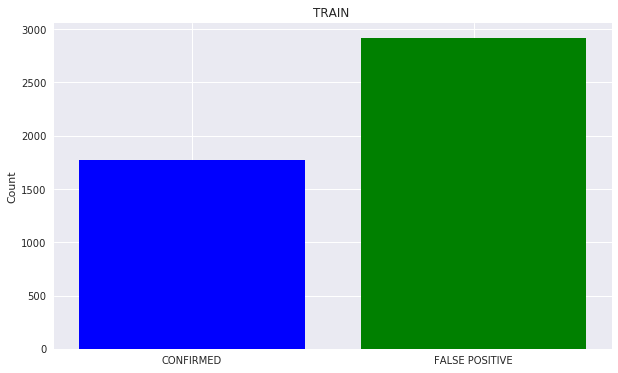

In [5]:
%matplotlib inline
plt.figure(figsize=(10,6))
plt.title("TRAIN ")
plt.bar(0, np.sum(y_train==1),color="blue")
plt.bar(1, np.sum(y_train==0),color="green")
plt.xticks([0,1],["CONFIRMED","FALSE POSITIVE"])
plt.ylabel("Count")

In [5]:
def plot_errors(X_plot, err_mask, mask_conf, mask_fp):
    mask_conf_Nerr = mask_conf & ~err_mask
    mask_conf_err = mask_conf & err_mask
    mask_fp_Nerr = mask_fp & ~err_mask
    mask_fp_err = mask_fp & err_mask

    plt.figure(figsize=(10,6))
    plt.scatter(X_plot[mask_conf_Nerr][:,0], X_plot[mask_conf_Nerr][:,1],label="CONFIRMED"
                , c='green', marker='o' ,alpha=0.2)
    plt.scatter(X_plot[mask_fp_Nerr][:,0], X_plot[mask_fp_Nerr][:,1],label="FALSE POSITIVE"
                , c='red', marker='o' ,alpha=0.2)

    #errors..
    plt.scatter(X_plot[mask_conf_err][:,0], X_plot[mask_conf_err][:,1],label="CONFIRMED"
                , c='green', marker='x', alpha=0.99, s=100)
    plt.scatter(X_plot[mask_fp_err][:,0], X_plot[mask_fp_err][:,1],label="FALSE POSITIVE"
                 , c='red', marker='x', alpha=0.99, s=100)
    plt.legend(loc='upper left')

## VARIAR REPRESENTACION ACA:

In [11]:
selec_feat = ['Metallicity err2', 'r/R', 'a/R', 'Duration err1',
       'Max Multievent sigma', 'Insolation Flux', 'KOI count',
       'Impact Parameter err2', 'Planet Radius', 'Time err1', 'r/R err1',
       'Slope', 'Duration', 'Period err2', 'Metallicity',
       'Impact Parameter err1', 'a/R err2', 'a/R err1', 'Q2',
       'Fitted Stellar Density']

In [6]:
df_rep_train = pd.read_csv('../Datos/OwnFats_unb/koi_light_curves_FATS2_metadata_train_model_p_error.csv').iloc[:,:-1]
df_rep_test = pd.read_csv('../Datos/OwnFats_unb/koi_light_curves_FATS2_metadata_test_model_p_error.csv').iloc[:,:-1]

#df_rep_train = df_rep_train[selec_feat]
#df_rep_test = df_rep_test[selec_feat]

#para fats2 
df_rep_train.fillna(df_rep_train.median(), inplace=True)
df_rep_test.fillna(df_rep_test.median(), inplace=True)
X_train = df_rep_train.values
X_test = df_rep_test.values
X_all_label = np.concatenate([X_train,X_test])

columns_names = df_rep_train.columns

print(X_train.shape)
X_all_label.shape

(4692, 72)


(6257, 72)

In [7]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,KernelPCA
std = StandardScaler()
std.fit(X_all_label)
Xstd_train = std.transform(X_train)
Xstd_test = std.transform(X_test)
Xstd_all_label = std.transform(X_all_label)

In [88]:
model = KernelPCA(kernel="rbf",n_components=2,fit_inverse_transform=True, gamma=0.05)
model.fit(Xstd_all_label)
Xstd_train_plot = model.transform(Xstd_train)

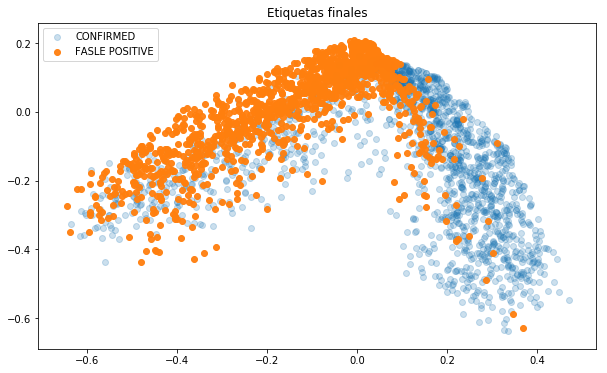

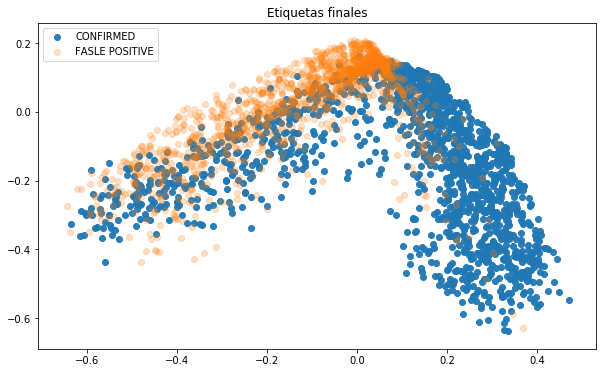

In [72]:
mask_con = y_train.astype('bool')
mask_fp = ~mask_con
plt.figure(figsize=(10,6))
plt.scatter(Xstd_train_plot[mask_con][:,0], Xstd_train_plot[mask_con][:,1],label="CONFIRMED",alpha=0.23)
plt.scatter(Xstd_train_plot[mask_fp][:,0], Xstd_train_plot[mask_fp][:,1],label="FASLE POSITIVE",alpha=0.95)

plt.title('Etiquetas finales')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(Xstd_train_plot[mask_con][:,0], Xstd_train_plot[mask_con][:,1],label="CONFIRMED",alpha=0.95)
plt.scatter(Xstd_train_plot[mask_fp][:,0], Xstd_train_plot[mask_fp][:,1],label="FASLE POSITIVE",alpha=0.23)

plt.title('Etiquetas finales')
plt.legend(loc='upper left')
plt.show()

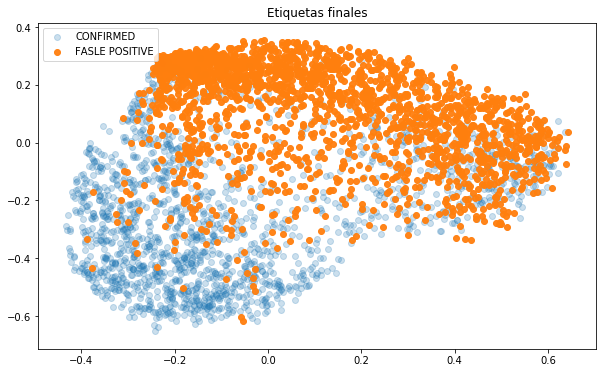

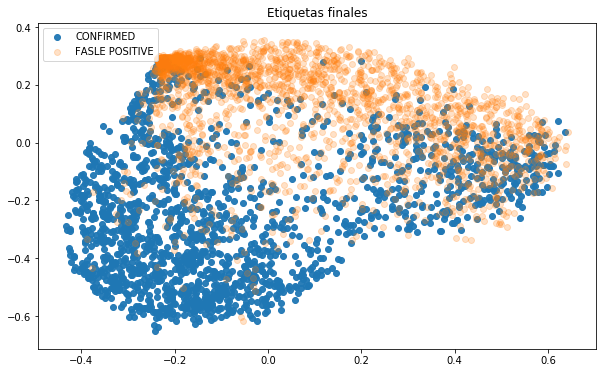

In [16]:
mask_con = y_train.astype('bool')
mask_fp = ~mask_con
plt.figure(figsize=(10,6))
plt.scatter(Xstd_train_plot[mask_con][:,0], Xstd_train_plot[mask_con][:,1],label="CONFIRMED",alpha=0.23)
plt.scatter(Xstd_train_plot[mask_fp][:,0], Xstd_train_plot[mask_fp][:,1],label="FASLE POSITIVE",alpha=0.95)

plt.title('Etiquetas finales')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(Xstd_train_plot[mask_con][:,0], Xstd_train_plot[mask_con][:,1],label="CONFIRMED",alpha=0.95)
plt.scatter(Xstd_train_plot[mask_fp][:,0], Xstd_train_plot[mask_fp][:,1],label="FASLE POSITIVE",alpha=0.23)

plt.title('Etiquetas finales')
plt.legend(loc='upper left')
plt.show()

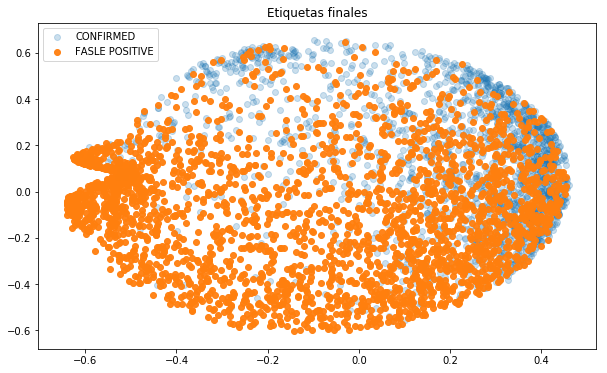

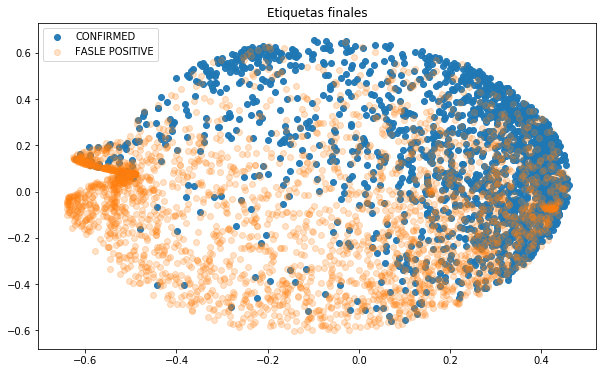

In [106]:
mask_con = y_train.astype('bool')
mask_fp = ~mask_con
plt.figure(figsize=(10,6))
plt.scatter(Xstd_train_plot[mask_con][:,0], Xstd_train_plot[mask_con][:,1],label="CONFIRMED",alpha=0.23)
plt.scatter(Xstd_train_plot[mask_fp][:,0], Xstd_train_plot[mask_fp][:,1],label="FASLE POSITIVE",alpha=0.95)

plt.title('Etiquetas finales')
plt.legend(loc='upper left')
plt.show()

plt.figure(figsize=(10,6))
plt.scatter(Xstd_train_plot[mask_con][:,0], Xstd_train_plot[mask_con][:,1],label="CONFIRMED",alpha=0.95)
plt.scatter(Xstd_train_plot[mask_fp][:,0], Xstd_train_plot[mask_fp][:,1],label="FASLE POSITIVE",alpha=0.23)

plt.title('Etiquetas finales')
plt.legend(loc='upper left')
plt.show()

### Start training models

In [8]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.metrics import make_scorer, f1_score, recall_score, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier


scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score),
    'f1_score_we':make_scorer(f1_score,average='weighted'),
    'f1_score_macro':make_scorer(f1_score,average='macro'),
    'f1_score_micro':make_scorer(f1_score,average='micro')
}

param_grid = {
    'n_estimators' : [10,20,30,40,50,60,70,80,90,100],
    'min_samples_split': [2,5,10,15,20,25],
    #'max_depth': np.arange(5,25),
    'class_weight' : ['balanced','balanced_subsample',None]
}

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Random Forest

In [9]:
clf = RandomForestClassifier(n_jobs=-1, random_state=0)

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit='f1_score_we',
                       cv=skf, return_train_score=False, n_jobs=-1)
grid_search.fit(X_train, y_train)

print('Best params for completeness:', grid_search.best_params_)
results = pd.DataFrame(grid_search.cv_results_)
bestResults = results[results.params == grid_search.best_params_]
completeness = float(bestResults['mean_test_recall_score'])
print('Completion: {:.4f}'.format(completeness))
preci = float(bestResults['mean_test_precision_score'])
print('Contamination: {:.4f}'.format(1-preci))
f1_w = float(bestResults['mean_test_f1_score_we'])
print('F1-score weighted: {:.4f}'.format(f1_w))
f1_ma = float(bestResults['mean_test_f1_score_macro'])
print('F1-score macro: {:.4f}'.format(f1_ma))
f1_mi = float(bestResults['mean_test_f1_score_micro'])
print('F1-score micro: {:.4f}'.format(f1_mi))

Best params for completeness: {'min_samples_split': 5, 'class_weight': None, 'n_estimators': 50}
Completion: 0.9212
Contamination: 0.0687
F1-score weighted: 0.9443
F1-score macro: 0.9407
F1-score micro: 0.9444


In [10]:
model = RandomForestClassifier(random_state=0,n_jobs=-1,**grid_search.best_params_) 
model.fit(X_train,y_train) 

ypred_train = model.predict(X_train)
ypred_test = model.predict(X_test)
ypred_all = np.concatenate([ypred_train,ypred_test])

err_train = ypred_train != y_train
err_test = ypred_test != y_test
err_all = np.concatenate([err_train,err_test])

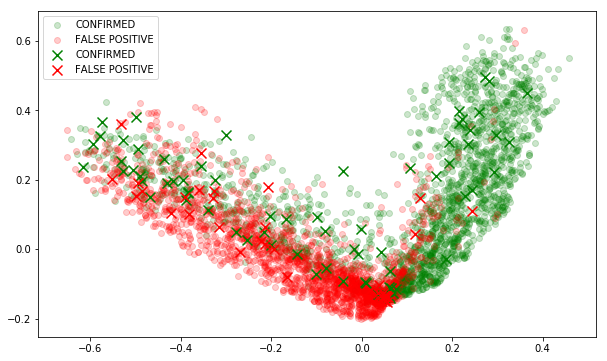

In [126]:
mask_con = ypred_all.astype('bool')
mask_fp = ~mask_con

plot_errors(Xstd_all_plot, err_all, mask_con, mask_fp) #0.15

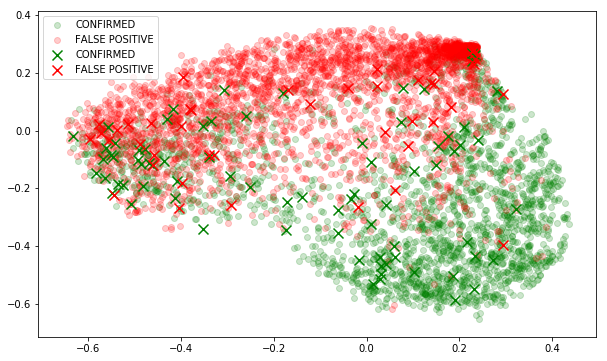

In [164]:
mask_con = ypred_all.astype('bool')
mask_fp = ~mask_con

plot_errors(Xstd_all_plot, err_all, mask_con, mask_fp) #0.05

### planetas conocidos

In [11]:
earth_dic = {'Period':365.0,
'Duration':13,
'r/R': 4.2635e-5/0.00465,
'Planet Radius':1, # con respecto a la tierra
'Semi-major Axis':1, #en unidades astronomicas -- a
'Teq': 279,
'a/R': 1/0.00465,
#'Limb Darkening Coeff1':,
#'Limb Darkening Coeff2':,
'Teff': 5777,
'Metallicity': 0, #con respecto al Fierro que tiene el sol
'Stellar Radius': 1, #con respecto al sol
'Stellar Mass': 1, #con respecto al sol
'KOI count':8}

mercury_dic = {'Period': 0.241*365.0,
'Duration': 8.1,
'r/R': 0.00350,
'Planet Radius': 0.384, # con respecto a la tierra
'Semi-major Axis': 0.387, #en unidades astronomicas -- a
'Teq': 449,
'a/R': np.nan,
#'Limb Darkening Coeff1':,
#'Limb Darkening Coeff2':,
'Teff': 5777,
'Metallicity': 0, #con respecto al Fierro que tiene el sol
'Stellar Radius': 1, #con respecto al sol
'Stellar Mass': 1, #con respecto al sol
'KOI count':8} #planetas en el sistema solar..

jupiter_dic = {'Period': 11.86*365.0,
'Duration':29.6,
'r/R':0.10049,
'Planet Radius': 10.9733, # con respecto a la tierra
'Semi-major Axis': 5.20336301, #en unidades astronomicas -- a
'Inclination':1.30530, #1.65, #no estoy seguro si es asi..
'Teq': 122,
'a/R': np.nan,
#'Limb Darkening Coeff1':,
#'Limb Darkening Coeff2':,
'Teff': 5777,
'Metallicity': 0, #con respecto al Fierro que tiene el sol
'Stellar Radius': 1, #con respecto al sol
'Stellar Mass': 1, #con respecto al sol
'KOI count':8} #planetas en el sistema solar.

In [37]:
#que metadatos plotear??
selec_feat = ["Planet Radius", "Teq", "Semi-major Axis", 
              #"Period", "Duration" , 
              #"a/R","r/R", # "Period", "Duration", "Inclination", "KOI count"
            "Stellar Mass" , "Stellar Radius", "Metallicity", "Teff"]

earth_data = np.asarray([[earth_dic[feat] for feat in selec_feat] ])
mercury_data = np.asarray([[mercury_dic[feat] for feat in selec_feat] ])
jupiter_data = np.asarray([[jupiter_dic[feat] for feat in selec_feat] ])

df_rep_train[selec_feat]

,Planet Radius,Teq,Semi-major Axis,Stellar Mass,Stellar Radius,Metallicity,Teff
0,1.17,844.0,0.052,0.727,0.751,-0.20,5037.0
1,1.86,303.0,0.789,0.864,1.187,-0.12,5604.0
2,36.62,804.0,0.075,0.796,0.702,-1.06,5951.0
3,9.19,5016.0,0.017,2.050,5.302,-0.10,6341.0
4,36.14,375.0,0.607,1.142,1.212,0.18,6018.0
5,2.41,931.0,0.091,1.035,1.220,0.16,5782.0
6,1.56,1053.0,0.023,0.654,0.651,-0.20,4506.0
7,100.20,2255.0,0.029,1.317,1.768,-0.22,6574.0
8,34.14,4454.0,0.051,3.584,20.848,0.07,4996.0
9,14.93,810.0,0.114,1.012,1.050,-0.14,6061.0


In [38]:
X_train = df_rep_train[selec_feat].values
X_test = df_rep_test[selec_feat].values
X_all_label = np.concatenate([X_train,X_test])

std = StandardScaler()
std.fit(X_all_label)

Xstd_all_label = std.transform(X_all_label)
earth_data = std.transform(earth_data)
mercury_data = std.transform(mercury_data)
jupiter_data = std.transform(jupiter_data)

/users/fmena/anaconda3/envs/tesis/lib/python3.5/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [39]:
model = KernelPCA(kernel="rbf",n_components=2,fit_inverse_transform=True, gamma=0.05) #0.15,0.05
model.fit(Xstd_all_label)

Xstd_all_plot = model.transform(Xstd_all_label)
earth_data_plot = model.transform(earth_data)
mercury_data_plot = model.transform(mercury_data)
jupiter_data_plot = model.transform(jupiter_data)

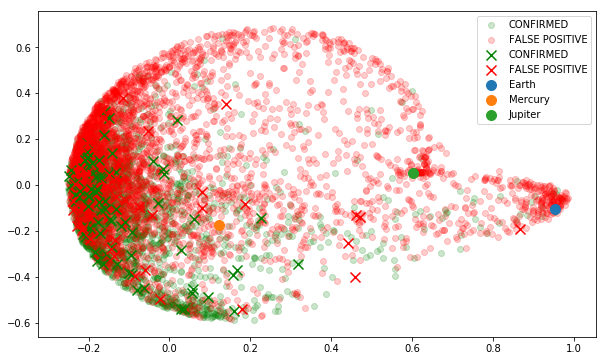

In [36]:
mask_con = ypred_all.astype('bool')
mask_fp = ~mask_con

plot_errors(Xstd_all_plot, err_all, mask_con, mask_fp)
plt.scatter(earth_data_plot[:,0], earth_data_plot[:,1], label="Earth", s=100)
plt.scatter(mercury_data_plot[:,0], mercury_data_plot[:,1], label="Mercury", s=100)
plt.scatter(jupiter_data_plot[:,0], jupiter_data_plot[:,1], label="Jupiter", s=100)
plt.legend()
plt.show() #0.05 ## con periodo y duration..

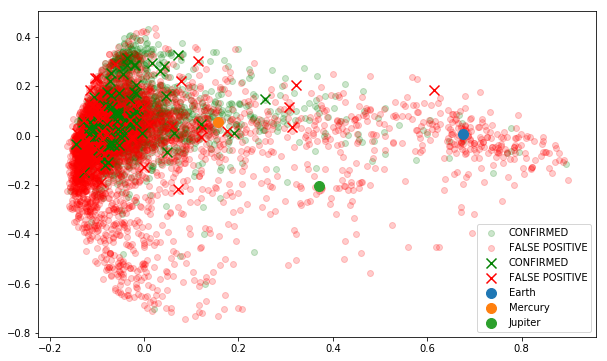

In [32]:
mask_con = ypred_all.astype('bool')
mask_fp = ~mask_con

plot_errors(Xstd_all_plot, err_all, mask_con, mask_fp)
plt.scatter(earth_data_plot[:,0], earth_data_plot[:,1], label="Earth", s=100)
plt.scatter(mercury_data_plot[:,0], mercury_data_plot[:,1], label="Mercury", s=100)
plt.scatter(jupiter_data_plot[:,0], jupiter_data_plot[:,1], label="Jupiter", s=100)
plt.legend()
plt.show() #0.01 ## con periodo y duration..

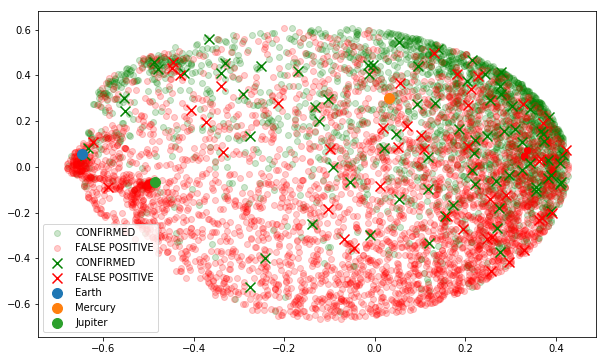

In [20]:
mask_con = ypred_all.astype('bool')
mask_fp = ~mask_con

plot_errors(Xstd_all_plot, err_all, mask_con, mask_fp)
plt.scatter(earth_data_plot[:,0], earth_data_plot[:,1], label="Earth", s=100)
plt.scatter(mercury_data_plot[:,0], mercury_data_plot[:,1], label="Mercury", s=100)
plt.scatter(jupiter_data_plot[:,0], jupiter_data_plot[:,1], label="Jupiter", s=100)
plt.legend()
plt.show() #0.15

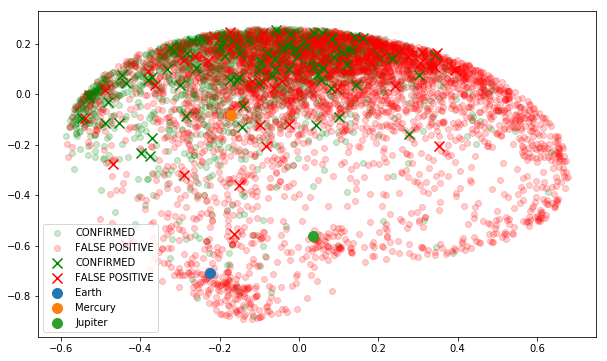

In [40]:
mask_con = ypred_all.astype('bool')
mask_fp = ~mask_con

plot_errors(Xstd_all_plot, err_all, mask_con, mask_fp)
plt.scatter(earth_data_plot[:,0], earth_data_plot[:,1], label="Earth", s=100)
plt.scatter(mercury_data_plot[:,0], mercury_data_plot[:,1], label="Mercury", s=100)
plt.scatter(jupiter_data_plot[:,0], jupiter_data_plot[:,1], label="Jupiter", s=100)
plt.legend()
plt.show() #0.05

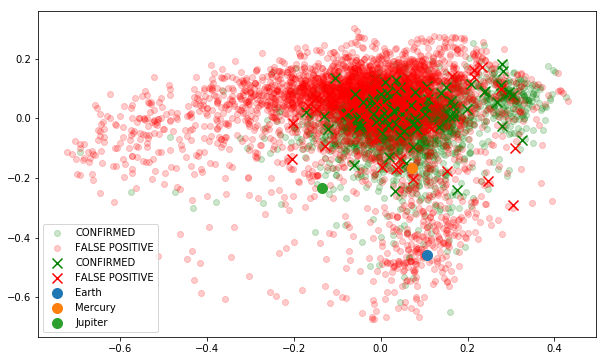

In [16]:
mask_con = ypred_all.astype('bool')
mask_fp = ~mask_con

plot_errors(Xstd_all_plot, err_all, mask_con, mask_fp)
plt.scatter(earth_data_plot[:,0], earth_data_plot[:,1], label="Earth", s=100)
plt.scatter(mercury_data_plot[:,0], mercury_data_plot[:,1], label="Mercury", s=100)
plt.scatter(jupiter_data_plot[:,0], jupiter_data_plot[:,1], label="Jupiter", s=100)
plt.legend()
plt.show() #0.01